In [1]:
import pandas as pd 
import os
import re
import numpy as np

from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from PIL import Image

In [2]:
BASE_PATH = os.path.join(os.getcwd(), os.pardir)
DATA_PATH = os.path.join(BASE_PATH, 'data')

In [14]:
train_df = pd.read_json('imputed_train.json')

# Extract text/numerical/categorical features

Let's extract out hte number of bathrooms and bedrooms, the building ID, the latitude, the longitude, the manager ID and the price since these are trivial to extract

In [16]:
bathrooms = train_df['bathrooms']
bedrooms = train_df['bedrooms']
building_ids = train_df['building_id']
latitudes = train_df['latitude']
longitudes = train_df['longitude']
manager_ids = train_df['manager_id']
prices = train_df['price']

Now we can extract the month, day, hour and weekday from the creation timestamp

In [17]:
datetime = pd.to_datetime(train_df['created'])

In [18]:
months = datetime.dt.month
days = datetime.dt.day
hours = datetime.dt.hour

In [19]:
# Where Monday = 0, and Sunday = 6
weekdays = datetime.dt.dayofweek

Now we can extract the number of pictures for each listing

In [20]:
num_photos = train_df['photos'].str.len()

Now let's extract the 'features' column, which is a harder task

Methodology of: https://www.kaggle.com/jxnlco/deduplicating-features

In [21]:
features = train_df['features'].apply(lambda x: [i.lower() for i in x])

We eliminate all features that appear less than $n$ times

In [22]:
n = 5

feature_counts = Counter()
for feature in features.tolist():
    feature_counts.update(feature)
feature = sorted([k for (k,v) in feature_counts.items() if v > n])
feature[:10]

['24/7 concierge',
 '24/7 doorman',
 '24hr doorman',
 'a full service luxury highrise',
 'actual apt. photos',
 'air conditioning',
 'all utilities included',
 'assigned-parking-space',
 'attended lobby',
 'backyard']

Since we have a lot of duplicates, we can clean things up to eliminate them. We use the first 4 characters of a feature in order to group together different features.

In [23]:
def clean(s):
    x = s.replace("-", "")
    x = x.replace(" ", "")
    x = x.replace("twenty four hour", "24")
    x = x.replace("24/7", "24")
    x = x.replace("24hr", "24")
    x = x.replace("24-hour", "24")
    x = x.replace("24hour", "24")
    x = x.replace("24 hour", "24")
    x = x.replace("common", "cm")
    x = x.replace("concierge", "doorman")
    x = x.replace("bicycle", "bike")
    x = x.replace("private", "pv")
    x = x.replace("deco", "dc")
    x = x.replace("decorative", "dc")
    x = x.replace("onsite", "os")
    x = x.replace("outdoor", "od")
    x = x.replace("ss appliances", "stainless")
    return x

def feature_hash(x):
    cleaned = clean(x, uniq)
    key = cleaned[:4].strip()
    return key

In [24]:
key2original = defaultdict(list)
k = 4
for f in feature:
    cleaned = clean(f)
    key = cleaned[:k].strip()
    key2original[key].append(f)

In [25]:
key2original

defaultdict(list,
            {'24do': ['24/7 concierge', '24/7 doorman', '24hr doorman'],
             'aful': ['a full service luxury highrise'],
             'actu': ['actual apt. photos'],
             'airc': ['air conditioning'],
             'allu': ['all utilities included'],
             'assi': ['assigned-parking-space'],
             'atte': ['attended lobby'],
             'back': ['backyard'],
             'balc': ['balcony'],
             'base': ['basement storage'],
             'bike': ['bike room', 'bike storage'],
             'bill': ['billiards room'],
             'brea': ['breakfast bar'],
             'brow': ['brownstone'],
             'buil': ['building-common-outdoor-space'],
             'busi': ['business center'],
             'cabl': ['cable/satellite tv'],
             'cats': ['cats allowed'],
             'cent': ['central a/c', 'central ac', 'central air'],
             'chef': ['chefs kitchen'],
             'chil': ["children's playroom", 'children

In [26]:
columns = list(key2original.keys())

In [27]:
original2key = {}
for col in columns:
    for original in key2original[col]:
        original2key[original] = col

In [28]:
original2key

{'24/7 concierge': '24do',
 '24/7 doorman': '24do',
 '24hr doorman': '24do',
 'a full service luxury highrise': 'aful',
 'actual apt. photos': 'actu',
 'air conditioning': 'airc',
 'all utilities included': 'allu',
 'assigned-parking-space': 'assi',
 'attended lobby': 'atte',
 'backyard': 'back',
 'balcony': 'balc',
 'basement storage': 'base',
 'bike room': 'bike',
 'bike storage': 'bike',
 'billiards room': 'bill',
 'breakfast bar': 'brea',
 'brownstone': 'brow',
 'building-common-outdoor-space': 'buil',
 'business center': 'busi',
 'cable/satellite tv': 'cabl',
 'cats allowed': 'cats',
 'central a/c': 'cent',
 'central ac': 'cent',
 'central air': 'cent',
 'chefs kitchen': 'chef',
 "children's playroom": 'chil',
 'childrens playroom': 'chil',
 'cinema room': 'cine',
 'city view': 'city',
 'close to subway': 'clos',
 'closets galore!': 'clos',
 'common backyard': 'cmba',
 'common garden': 'cmga',
 'common outdoor space': 'cmod',
 'common parking/garage': 'cmpa',
 'common roof deck': 

In [29]:
all_listing_features = {}

for index,row in train_df.iterrows():
    listing_features = {}
    features_found = []
    for feature in row['features']:
        feature = feature.lower()
        if feature in original2key:
            features_found.append(original2key[feature])
    for feature in columns:
            if feature not in features_found:
                listing_features[feature] = 0
            else:
                listing_features[feature] = 1
    all_listing_features[row['listing_id']] = listing_features
    
one_hot_features = pd.DataFrame.from_dict(all_listing_features, orient='index')

In [30]:
one_hot_features

,24do,aful,actu,airc,allu,assi,atte,back,balc,base,...,tons,vale,vide,view,virt,walk,wash,whee,wifi,wood
6811957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6811965,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6811966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6811973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6811975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6812000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6812002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6812004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6812005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6812009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can try extracting features from the "Description" column

Methodology of: https://www.kaggle.com/ug2409/using-description-as-the-only-feature-72-cv

In [31]:
descriptions = train_df[['description']]

In [32]:
# Removes symbols, numbers and stem the words to reduce dimentional space
stemmer = PorterStemmer()

def clean(x):
    regex = re.compile('[^a-zA-Z ]')
    # For user clarity, broken it into three steps
    i = regex.sub(' ', x).lower()
    i = i.split(" ") 
    i= [stemmer.stem(l) for l in i]
    i= " ".join([l.strip() for l in i if (len(l)>2) ]) # Keeping words that have length greater than 2
    return i

In [33]:
descriptions['description_new'] = descriptions.description.apply(lambda x: clean(x))

/home/matthew/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
descriptions.head()

,description,description_new
10,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,brand new bedroom bath apartmentenjoy these fo...
10000,,
100004,"Top Top West Village location, beautiful Pre-w...",top top west villag locat beauti pre war build...
100007,Building Amenities - Garage - Garden - fitness...,build amen garag garden fit room laundri room ...
100013,Beautifully renovated 3 bedroom flex 4 bedroom...,beauti renov bedroom flex bedroom apart for re...


In [35]:
from sklearn.feature_extraction.text import CountVectorizer #Can use tfidffvectorizer as well

cvect_desc = CountVectorizer(stop_words='english', max_features=200)
full_sparse = cvect_desc.fit_transform(descriptions.description_new)

# Renaming words to avoid collisions with other feature names in the model
col_desc = ['desc_'+ i for i in cvect_desc.get_feature_names()] 
count_vect_df = pd.DataFrame(full_sparse.todense(), columns=col_desc)
descriptions = pd.concat([descriptions.reset_index(), count_vect_df],axis=1)

In [36]:
descriptions = descriptions.drop(labels=['description', 'index', 'description_new'], axis=1)

In [37]:
descriptions.index = train_df['listing_id']
descriptions

,desc_access,desc_allow,desc_amaz,desc_amen,desc_amp,desc_ani,desc_apart,desc_applianc,desc_appoint,desc_area,...,desc_walk,desc_wall,desc_washer,desc_water,desc_websit,desc_west,desc_white,desc_window,desc_wood,desc_york
listing_id,,,,,,,,,,,,,,,,,,,,,
7211212,0,0,0,0,0,0,2,1,0,1,...,0,0,1,0,1,0,0,0,0,0
7150865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6887163,0,0,0,0,0,1,2,0,0,0,...,0,0,0,0,1,1,0,0,0,1
6888711,0,0,0,1,0,0,1,0,0,1,...,1,0,0,0,1,0,0,0,0,0
6934781,0,0,0,0,0,0,3,1,1,0,...,0,2,1,0,0,0,0,0,1,0
6894514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6930771,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
6867392,1,0,1,0,0,1,3,1,0,1,...,0,0,1,0,1,1,0,0,0,0
6898799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Now we can make one final dataframe which has all the columns. We can perform feature selection on this at a later time.

In [38]:
final_train_df = pd.DataFrame()

In [39]:
final_train_df['bathrooms'] = bathrooms
final_train_df['bedrooms'] = bedrooms
final_train_df['building_ids'] = building_ids 
final_train_df['latitudes'] = latitudes
final_train_df['longitudes'] = longitudes
final_train_df['manager_ids'] = manager_ids
final_train_df['prices'] = prices

In [40]:
final_train_df['months'] = months
final_train_df['days'] = days
final_train_df['hours'] = hours
final_train_df['weekdays'] = weekdays

In [41]:
final_train_df['num_photos'] = num_photos

In [42]:
final_train_df.index = train_df['listing_id']
final_train_df

,bathrooms,bedrooms,building_ids,latitudes,longitudes,manager_ids,prices,months,days,hours,weekdays,num_photos
listing_id,,,,,,,,,,,,
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,3000,6,24,7,4,5
7150865,1.0,2,c5c8a357cba207596b04d1afd1e4f130,40.7947,-73.9667,7533621a882f71e25173b27e3139d83d,5465,6,12,12,6,11
6887163,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,40.7388,-74.0018,d9039c43983f6e564b1482b273bd7b01,2850,4,17,3,6,8
6888711,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,40.7539,-73.9677,1067e078446a7897d2da493d2f741316,3275,4,18,2,0,3
6934781,1.0,4,0,40.8241,-73.9493,98e13ad4b495b9613cef886d79a6291f,3350,4,28,1,3,3
6894514,2.0,4,38a913e46c94a7f46ddf19b756a9640c,40.7429,-74.0028,b209e2c4384a64cc307c26759ee0c651,7995,4,19,4,1,5
6930771,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,40.8012,-73.9660,01287194f20de51872e81f660def4784,3600,4,27,3,2,10
6867392,2.0,1,0372927bcb6a0949613ef5bf893bbac7,40.7427,-73.9957,e6472c7237327dd3903b3d6f6a94515a,5645,4,13,6,2,5
6898799,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,40.8234,-73.9457,c1a6598437b7db560cde66e5a297a53f,1725,4,20,2,2,5


In [43]:
final_train_df = final_train_df.merge(descriptions, left_index=True, right_index=True)

In [44]:
final_train_df = final_train_df.merge(one_hot_features, left_index=True, right_index=True)

Now we can perform one-hot encoding on the building_ids and manager_ids

In [45]:
final_train_df = pd.concat([final_train_df, pd.get_dummies(final_train_df['building_ids'], prefix='building')], axis=1)
final_train_df = pd.concat([final_train_df, pd.get_dummies(final_train_df['manager_ids'], prefix='manager')], axis=1)

In [46]:
final_train_df = final_train_df.drop(['building_ids', 'manager_ids'], axis=1)

In [47]:
final_train_df

,bathrooms,bedrooms,latitudes,longitudes,prices,months,days,hours,weekdays,num_photos,...,manager_ff50149b1ec6a10fbb386d761c7a4bc5,manager_ff52574a198d8a349f41d57bd374e8e9,manager_ff564542a40d3e9b970a494df91b4cee,manager_ff5a3509ebce238dfa4857839ddd24ce,manager_ff707b7f0a2ea94a26c784f06c9fec69,manager_ff810b43aecfacd00f20a2912ff1e288,manager_ff8f1175d95c5a866ef73399cd54a1a1,manager_ffb9eceeaa4d60da7b41cc8f0954cd50,manager_ffd3c60281949a5cd806030203a79558,manager_ffd7307e4924587b30ec014a95db1362
7211212,1.5,3,40.7145,-73.9425,3000,6,24,7,4,5,...,0,0,0,0,0,0,0,0,0,0
7150865,1.0,2,40.7947,-73.9667,5465,6,12,12,6,11,...,0,0,0,0,0,0,0,0,0,0
6887163,1.0,1,40.7388,-74.0018,2850,4,17,3,6,8,...,0,0,0,0,0,0,0,0,0,0
6888711,1.0,1,40.7539,-73.9677,3275,4,18,2,0,3,...,0,0,0,0,0,0,0,0,0,0
6934781,1.0,4,40.8241,-73.9493,3350,4,28,1,3,3,...,0,0,0,0,0,0,0,0,0,0
6894514,2.0,4,40.7429,-74.0028,7995,4,19,4,1,5,...,0,0,0,0,0,0,0,0,0,0
6930771,1.0,2,40.8012,-73.9660,3600,4,27,3,2,10,...,0,0,0,0,0,0,0,0,0,0
6867392,2.0,1,40.7427,-73.9957,5645,4,13,6,2,5,...,0,0,0,0,0,0,0,0,0,0
6898799,1.0,1,40.8234,-73.9457,1725,4,20,2,2,5,...,0,0,0,0,0,0,0,0,0,0
6814332,2.0,4,40.7278,-73.9808,5800,4,2,2,5,9,...,0,0,0,0,0,0,0,0,0,0


Let's calculate the mutual information for the target variable to get a head start on feature selection

In [34]:
from sklearn.feature_selection import mutual_info_classif

In [56]:
# For the main features
mutual_info_classif(final_train_df[['bathrooms', 'bedrooms', 'latitudes', 'longitudes', 'prices',
                                    'months', 'days', 'hours', 'weekdays', 'num_photos']], 
                                   train_df['interest_level'], random_state=667)

array([0.01400252, 0.00873072, 0.04042343, 0.03000614, 0.05876936,
       0.00231721, 0.00469537, 0.03053344, 0.        , 0.02422371])

We see that 'weekday' has a mutual info value of 0, meaning it is not important and is independent from the target labels. Now let's check this out for the one-hot encoded features

In [60]:
values = mutual_info_classif(descriptions, train_df['interest_level'], random_state=667)
values

array([3.07965841e-03, 0.00000000e+00, 2.61793018e-03, 3.58251950e-03,
       5.83791054e-03, 0.00000000e+00, 4.01113097e-05, 4.17201904e-03,
       1.15129589e-04, 0.00000000e+00, 8.91575917e-04, 0.00000000e+00,
       2.77387634e-04, 0.00000000e+00, 3.25647799e-03, 0.00000000e+00,
       5.58796287e-04, 0.00000000e+00, 4.91915044e-03, 2.71003189e-03,
       1.89450293e-03, 1.93635995e-03, 0.00000000e+00, 2.82918069e-03,
       2.46602156e-03, 2.38778741e-04, 0.00000000e+00, 0.00000000e+00,
       3.64035226e-03, 0.00000000e+00, 6.84479465e-04, 2.01959702e-03,
       0.00000000e+00, 2.00550262e-03, 1.76325343e-03, 2.13647306e-03,
       0.00000000e+00, 7.69864350e-03, 1.25789563e-03, 2.42976194e-03,
       3.02932437e-03, 4.18282236e-03, 0.00000000e+00, 4.80206172e-04,
       1.13388700e-03, 2.66789812e-03, 4.79801710e-04, 0.00000000e+00,
       3.61480463e-03, 1.40578760e-03, 3.28071620e-04, 3.62588906e-03,
       0.00000000e+00, 3.40291265e-03, 0.00000000e+00, 0.00000000e+00,
      

In [61]:
max(values)

0.014328444988887634

In [62]:
values = mutual_info_classif(one_hot_features, train_df['interest_level'], random_state=667)
values

array([0.00000000e+00, 1.22475661e-03, 1.49649635e-03, 6.15803149e-06,
       1.32427565e-03, 1.55443608e-03, 0.00000000e+00, 0.00000000e+00,
       3.75819580e-03, 0.00000000e+00, 1.54171636e-03, 0.00000000e+00,
       2.29911354e-03, 9.97463401e-04, 0.00000000e+00, 2.31064414e-03,
       0.00000000e+00, 5.50238527e-03, 3.37911356e-04, 2.48216600e-03,
       0.00000000e+00, 3.37525363e-04, 0.00000000e+00, 0.00000000e+00,
       1.02898991e-03, 0.00000000e+00, 0.00000000e+00, 2.14312623e-03,
       0.00000000e+00, 0.00000000e+00, 1.00316834e-04, 1.19715118e-03,
       1.81247249e-03, 3.85060802e-04, 4.18661599e-04, 0.00000000e+00,
       1.71899494e-03, 4.64816689e-05, 2.86926992e-03, 9.14897964e-03,
       3.12241634e-03, 3.73253873e-03, 1.69926372e-03, 1.36427271e-03,
       0.00000000e+00, 6.94981495e-03, 0.00000000e+00, 1.71508013e-03,
       1.99342688e-03, 1.72881301e-03, 0.00000000e+00, 1.10106051e-03,
       0.00000000e+00, 1.89643738e-03, 6.30424542e-03, 0.00000000e+00,
      

In [63]:
max(values)

0.013985754946577611

In [49]:
# Output it to a csv
# final_train_df.to_csv(os.path.join(DATA_PATH, 'train_feats.tsv'), sep='\t')
final_train_df.to_json(os.path.join(DATA_PATH, 'train_feats.json'))

# Extract image data 

## Creating a new dataframe for images

Included with the Kaggle dataset is a sample of photos for 100 listings. We want to create a new dataframe for these images, so that we can organize the data, as well as find new, interesting features.

In [35]:
IMG_PATH = os.path.join(DATA_PATH, 'images_sample')

In [47]:
# Each folder is a listing ID
img_folders = os.listdir(IMG_PATH)

In [51]:
# img_df has two columns for now
# img -> the actual Image object itself
# listing_id -> references the original listing that the photo belongs to
img_df = pd.DataFrame(columns=['image', 'listing_id'])
img_df

In [59]:
# Iterate over all folders (listing id)
for img_folder in img_folders:
    
    img_dir = os.path.join(IMG_PATH, img_folder)
    all_imgs = os.listdir(img_dir)
    
    # Iterate over all images inside each folder
    for img in all_imgs:
        img_path = os.path.join(img_dir, img)
        row = {'image': None, 'listing_id': None}
        row['listing_id'] = img_folder
        
        # Create an Image object using the Pillow library, then save into dataframe
        row['image'] = Image.open(img_path)
        img_df = img_df.append(row, ignore_index = True)

In [62]:
img_df.head()

,image,listing_id
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,6811957
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,6811957
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,6811957
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,6811957
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,6811957


## Image exploration

In [134]:
img_df.iloc[0]

image         <PIL.JpegImagePlugin.JpegImageFile image mode=...
listing_id                                              6811957
Name: 0, dtype: object

In [67]:
img = img_df.iloc[0].image

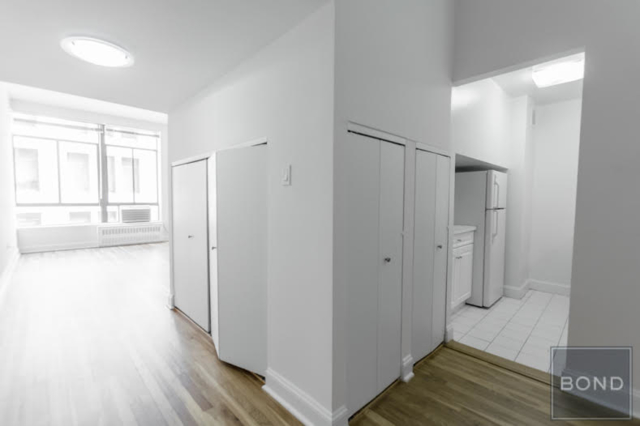

In [68]:
img

We can extract RGB pixel values as each color image has 3 channels.

In [69]:
r,g,b = img.split()

As an example, we show the blue channel.

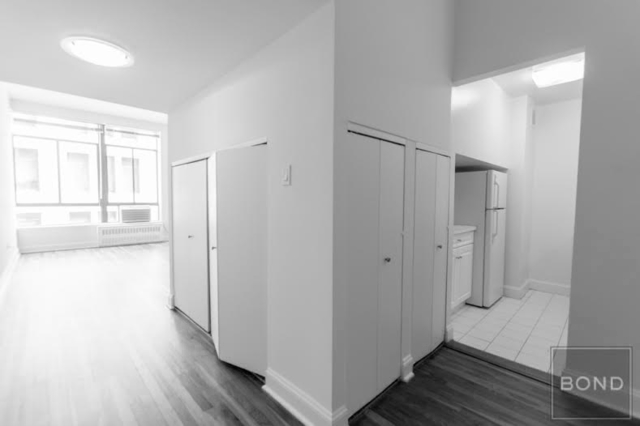

In [75]:
b

Note that the blue channel is simply a monochrome image in and of itself. That's because there is only one channel. 

Now we can calculate some basic statistics for the images which may (or may not) be useful in predicting interest level.

### Mean and standard deviation

We can separately compute the mean and standard deviation for each of the three channels. This yields 3*2 = 6 new features.

In [88]:
r_arr = np.array(r.getdata())
g_arr = np.array(g.getdata())
b_arr = np.array(b.getdata())

In [89]:
r_mean = r_arr.mean()
g_mean = g_arr.mean()
b_mean = b_arr.mean()

In [90]:
# The mean red pixel value for the entire image.
r_mean

178.78016431924883

In [91]:
r_std = r_arr.std()
g_std = g_arr.std()
b_std = b_arr.std()

In [100]:
# Standard deviation for the green pixel value.
g_std

44.596423661626275

## Color histogram
For each channel, we can compute the distribution, which allows us to construct a histogram as follows.

In [106]:
r_hist = r.histogram()
g_hist = g.histogram()
b_hist = b.histogram()

<Figure size 432x288 with 0 Axes>

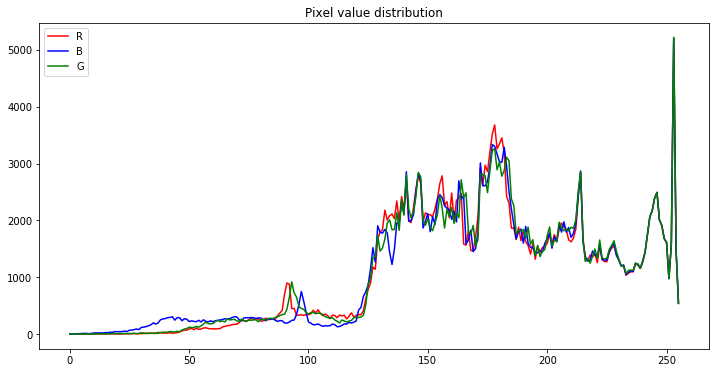

In [139]:
plt.clf()
plt.figure(figsize=(12,6))
plt.plot(r_hist, c='red', label='R')
plt.plot(b_hist, c='blue', label='B')
plt.plot(g_hist, c='green', label='G')
plt.title("Pixel value distribution")
plt.legend()
plt.show()

The histogram itself might be useful as a feature, but since each histogram consists of 256 numbers and there are 3 histograms, this is too many features. Instead, we can find the most dominant pixel value for each channel (i.e. the argmax).

This gives us 3 additional features, for a running total of 9.

In [109]:
r_dom = np.argmax(r_hist)
g_dom = np.argmax(g_hist)
b_dom = np.argmax(b_hist)

In [110]:
# Most dominant value in the blue channel
b_dom

253

## Dominant color

While calculating statistics for each channel separately might yield nine features, these values are somewhat misleading in that they do not consider the other two channels. It is clear that none of the color channels are independent from any other.

Thus, it may be more informative to look at all 3 channels at once (i.e. treat each pixel as a 3-vector). However, rather than trying to calculate the mean or standard deviation, we can find the most "dominant" color. This could mean one of two things:

1) Compute the most frequent RGB vector, in a similar manner as computing r_dom, g_dom and b_dom.

2) Use k-means clustering to find the most dominant RGB vector.

https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image

## Standard approach
The first approach is to do a raw count of each 3-tuple (R, G, B) that occurs in the image, and take the maximum.

In [124]:
pixel_values = np.array(img.getdata())

In [125]:
pixel_values

array([[202, 202, 202],
       [202, 202, 202],
       [202, 202, 202],
       ...,
       [ 64,  55,  40],
       [ 64,  55,  38],
       [ 64,  55,  40]])

In [128]:
# Computes the mode row of a 2-dimensional matrix.
# taken from 
# https://stackoverflow.com/questions/43554819/find-most-frequent-row-or-mode-of-a-matrix-of-vectors-python-numpy

def mode_rows(a):
    a = np.ascontiguousarray(a)
    void_dt = np.dtype((np.void, a.dtype.itemsize * np.prod(a.shape[1:])))
    _,ids, count = np.unique(a.view(void_dt).ravel(), \
                                return_index=1,return_counts=1)
    largest_count_id = ids[count.argmax()]
    most_frequent_row = a[largest_count_id]
    return most_frequent_row

In [129]:
dominant_mode = mode_rows(pixel_values)
dominant_mode

array([253, 253, 253])

## K-means clustering
We use the following Python snippet obtained from https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image to calculate the dominant color.

First we find cluster centres via k-means clustering. # of clusters is set to 5. Then we assign each pixel to one of the clusters (based on which cluster centre is closest). Finally, we count the size of each cluster, and take the maximum.

In [104]:
import scipy
import scipy.misc
import scipy.cluster
import binascii

In [105]:
NUM_CLUSTERS = 5

print('reading image')
im = img
im = im.resize((150, 150))      # optional, to reduce time
ar = np.asarray(im)
shape = ar.shape
ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

print('finding clusters')
codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
print('cluster centres:\n', codes)

vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

index_max = scipy.argmax(counts)                    # find most frequent
peak = codes[index_max]
colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
print('most frequent is %s (#%s)' % (peak, colour))

reading image
finding clusters
cluster centres:
 [[209.39292196 210.05898367 209.74319419]
 [242.43389918 242.47916667 242.47196502]
 [175.90558531 177.0544759  176.27666412]
 [ 91.46115906  85.16091245  67.69605425]
 [142.62923764 142.74698197 141.41210518]]
most frequent is [175.90558531 177.0544759  176.27666412] (#afb1b0)


In [133]:
# Dominant cluster centre is float, so round then convert to int
dominant_kmeans = np.round(peak).astype(int)
dominant_kmeans

array([176, 177, 176])

Note that the most frequent pixel value (253, 253, 253) is significantly different from the dominant color found by k-means clustering (176, 177, 176). The k-means dominant color can roughly be interpreted as the most dominant "representative" color out of the five representative colors (which are the centroids of the k-means algorithm). Since the computation of the centroids uses the entire dataset, the k-means dominant color may be slightly more informative than simply using the mode pixel.